In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [30]:
# config
z_threshold = 10

relation = 0.05

In [31]:
pd.set_option('display.max_columns', None)

In [32]:
train = pd.read_csv('./Data/train.csv')
test = pd.read_csv('./Data/test.csv')

In [33]:
duplicatedSmiles = train['SMILES'].duplicated(keep=False)
duplicates = train[duplicatedSmiles].sort_values(by='SMILES')
duplicates

,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
2276,TRAIN_2276,C(=C/c1nnn(Cc2ccccc2)n1)\c1ccccc1,1.535,31.453,3.556,262.309,3,0,4,3.556,43.60
451,TRAIN_0451,C(=C/c1nnn(Cc2ccccc2)n1)\c1ccccc1,0.310,24.670,3.556,262.309,3,0,4,3.556,43.60
2891,TRAIN_2891,CC(=O)Nc1ccc(N2N=C(c3ccc(O)cc3)C(C)CC2=O)cc1,55.950,69.950,2.172,337.372,4,2,3,2.169,82.00
543,TRAIN_0543,CC(=O)Nc1ccc(N2N=C(c3ccc(O)cc3)C(C)CC2=O)cc1,68.485,85.872,2.172,337.372,4,2,3,2.169,82.00
837,TRAIN_0837,CC(=O)Nc1nc2ccc(-c3nn(C(C)C)c4nc(N)ncc34)cc2s1,63.522,62.488,2.293,367.428,5,2,3,2.307,139.85
366,TRAIN_0366,CC(=O)Nc1nc2ccc(-c3nn(C(C)C)c4nc(N)ncc34)cc2s1,73.740,66.850,2.293,367.428,5,2,3,2.307,139.85
1085,TRAIN_1085,CC(C)(C)OC(=O)N1CCC(c2n[nH]c3nc(S(C)(=O)=O)ncc...,23.630,71.470,1.684,381.450,7,1,4,1.684,126.52
2848,TRAIN_2848,CC(C)(C)OC(=O)N1CCC(c2n[nH]c3nc(S(C)(=O)=O)ncc...,40.657,99.900,1.684,381.450,7,1,4,1.684,126.52
2096,TRAIN_2096,CC(C)COc1cc(=O)n2c(c1C(=O)N1CCC(C)CC1)CCCCC2,1.880,61.280,2.843,360.490,3,0,4,2.843,49.85
1666,TRAIN_1666,CC(C)COc1cc(=O)n2c(c1C(=O)N1CCC(C)CC1)CCCCC2,5.494,25.397,2.843,360.490,3,0,4,2.843,49.85


In [34]:
# 중복 약의 경우 기준값에 따라 max와 median을 취함
def custom_duplication(group):
    max_val = group.max()
    min_val = group.min()
    med_val = group.median()
    
    return max_val if max_val - min_val > 10 else med_val

train["MLM"] = train.groupby(by=["SMILES"])["MLM"].transform(custom_duplication)
train["HLM"] = train.groupby(by=["SMILES"])["HLM"].transform(custom_duplication)

train = train.drop_duplicates().reset_index(drop=True)

In [35]:
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski, Crippen, MolSurf, Fragments
from rdkit.Chem.EState import EState_VSA
from rdkit.Chem.GraphDescriptors import (
    BalabanJ, BertzCT, Chi0, Chi0n, Chi0v, Chi1, Chi1n, Chi1v, Chi2n, Chi2v, Chi3n, Chi3v, Chi4n, Chi4v, HallKierAlpha, Ipc, Kappa1, Kappa2, Kappa3
)
from rdkit.Chem.EState.EState_VSA import (EState_VSA1, EState_VSA10, EState_VSA11, EState_VSA2, EState_VSA3,
    EState_VSA4, EState_VSA5, EState_VSA6, EState_VSA7, EState_VSA8, EState_VSA9, VSA_EState1, VSA_EState10,
    VSA_EState2, VSA_EState3, VSA_EState4, VSA_EState5, VSA_EState6, VSA_EState7, VSA_EState8, VSA_EState9
)
from rdkit.Chem.Descriptors import (ExactMolWt, MolWt, HeavyAtomMolWt, MaxAbsPartialCharge, MinPartialCharge,
    MaxPartialCharge, MinAbsPartialCharge, NumRadicalElectrons, NumValenceElectrons
)
from rdkit.Chem.EState.EState import MaxAbsEStateIndex, MaxEStateIndex, MinAbsEStateIndex, MinEStateIndex
from rdkit.Chem.Lipinski import (
    FractionCSP3, HeavyAtomCount, NHOHCount, NOCount, NumAliphaticCarbocycles, NumAliphaticHeterocycles, NumAliphaticRings,
    NumAromaticCarbocycles, NumAromaticHeterocycles, NumAromaticRings, NumHAcceptors, NumHDonors, NumHeteroatoms, RingCount,
    NumRotatableBonds, NumSaturatedCarbocycles, NumSaturatedHeterocycles, NumSaturatedRings
)
from rdkit.Chem.Crippen import MolLogP, MolMR
from rdkit.Chem.MolSurf import (
    LabuteASA, PEOE_VSA1, PEOE_VSA10, PEOE_VSA11, PEOE_VSA12, PEOE_VSA13, PEOE_VSA14, PEOE_VSA2, PEOE_VSA3, PEOE_VSA4, PEOE_VSA5,
    PEOE_VSA6, PEOE_VSA7, PEOE_VSA8, PEOE_VSA9, SMR_VSA1, SMR_VSA10, SMR_VSA2, SMR_VSA3, SMR_VSA4, SMR_VSA5, SMR_VSA6, SMR_VSA7,
    SMR_VSA8, SMR_VSA9, SlogP_VSA1, SlogP_VSA10, SlogP_VSA11, SlogP_VSA12, SlogP_VSA2, SlogP_VSA3, SlogP_VSA4, SlogP_VSA5,
    SlogP_VSA6, SlogP_VSA7, SlogP_VSA8, SlogP_VSA9, TPSA
)
from rdkit.Chem.Fragments import (
    fr_Al_COO, fr_Al_OH, fr_Al_OH_noTert, fr_ArN, fr_Ar_COO, fr_Ar_N, fr_Ar_NH, fr_Ar_OH, fr_COO, fr_COO2, fr_C_O, fr_C_O_noCOO,
    fr_C_S, fr_HOCCN, fr_Imine, fr_NH0, fr_NH1, fr_NH2, fr_N_O, fr_Ndealkylation1, fr_Ndealkylation2, fr_Nhpyrrole, fr_SH,
    fr_aldehyde, fr_alkyl_carbamate, fr_alkyl_halide, fr_allylic_oxid, fr_amide, fr_amidine, fr_aniline, fr_aryl_methyl,
    fr_azide, fr_azo, fr_barbitur, fr_benzene, fr_benzodiazepine, fr_bicyclic, fr_diazo, fr_dihydropyridine, fr_epoxide,
    fr_ester, fr_ether, fr_furan, fr_guanido, fr_halogen, fr_hdrzine, fr_hdrzone, fr_imidazole, fr_imide, fr_isocyan,
    fr_isothiocyan, fr_ketone, fr_ketone_Topliss, fr_lactam, fr_lactone, fr_methoxy, fr_morpholine, fr_nitrile, fr_nitro,
    fr_nitro_arom, fr_nitro_arom_nonortho, fr_nitroso, fr_oxazole, fr_oxime, fr_para_hydroxylation, fr_phenol,
    fr_phenol_noOrthoHbond, fr_phos_acid, fr_phos_ester, fr_piperdine, fr_piperzine, fr_priamide, fr_prisulfonamd,
    fr_pyridine, fr_quatN, fr_sulfide, fr_sulfonamd, fr_sulfone, fr_term_acetylene, fr_tetrazole, fr_thiazole, fr_thiocyan,
    fr_thiophene, fr_unbrch_alkane, fr_urea
)

def add_feature(smiles):
    mol = Chem.MolFromSmiles(smiles)
    descriptors = {
        'BalabanJ': BalabanJ(mol),
        'BertzCT': BertzCT(mol),
        'Chi0': Chi0(mol),
        'Chi0n': Chi0n(mol),
        'Chi0v': Chi0v(mol),
        'Chi1': Chi1(mol),
        'Chi1n': Chi1n(mol),
        'Chi1v': Chi1v(mol),
        'Chi2n': Chi2n(mol),
        'Chi2v': Chi2v(mol),
        'Chi3n': Chi3n(mol),
        'Chi3v': Chi3v(mol),
        'Chi4n': Chi4n(mol),
        'Chi4v': Chi4v(mol),
        'EState_VSA1': EState_VSA1(mol),
        'EState_VSA10': EState_VSA10(mol),
        'EState_VSA11': EState_VSA11(mol),
        'EState_VSA2': EState_VSA2(mol),
        'EState_VSA3': EState_VSA3(mol),
        'EState_VSA4': EState_VSA4(mol),
        'EState_VSA5': EState_VSA5(mol),
        'EState_VSA6': EState_VSA6(mol),
        'EState_VSA7': EState_VSA7(mol),
        'EState_VSA8': EState_VSA8(mol),
        'EState_VSA9': EState_VSA9(mol),
        'ExactMolWt': ExactMolWt(mol),
        'FractionCSP3': FractionCSP3(mol),
        'HallKierAlpha': HallKierAlpha(mol),
        'HeavyAtomCount': HeavyAtomCount(mol),
        'HeavyAtomMolWt': HeavyAtomMolWt(mol),
        'Ipc': Ipc(mol),
        'Kappa1': Kappa1(mol),
        'Kappa2': Kappa2(mol),
        'Kappa3': Kappa3(mol),
        'LabuteASA': LabuteASA(mol),
        'MaxAbsEStateIndex': MaxAbsEStateIndex(mol),
        'MaxAbsPartialCharge': MaxAbsPartialCharge(mol),
        'MaxEStateIndex': MaxEStateIndex(mol),
        'MaxPartialCharge': MaxPartialCharge(mol),
        'MinAbsEStateIndex': MinAbsEStateIndex(mol),
        'MinAbsPartialCharge': MinAbsPartialCharge(mol),
        'MinEStateIndex': MinEStateIndex(mol),
        'MinPartialCharge': MinPartialCharge(mol),
        'MolLogP': MolLogP(mol),
        'MolMR': MolMR(mol),
        'MolWt': MolWt(mol),
        'NHOHCount': NHOHCount(mol),
        'NOCount': NOCount(mol),
        'NumAliphaticCarbocycles': NumAliphaticCarbocycles(mol),
        'NumAliphaticHeterocycles': NumAliphaticHeterocycles(mol),
        'NumAliphaticRings': NumAliphaticRings(mol),
        'NumAromaticCarbocycles': NumAromaticCarbocycles(mol),
        'NumAromaticHeterocycles': NumAromaticHeterocycles(mol),
        'NumAromaticRings': NumAromaticRings(mol),
        'NumHAcceptors': NumHAcceptors(mol),
        'NumHDonors': NumHDonors(mol),
        'NumHeteroatoms': NumHeteroatoms(mol),
        'NumRadicalElectrons': NumRadicalElectrons(mol),
        'NumRotatableBonds': NumRotatableBonds(mol),
        'NumSaturatedCarbocycles': NumSaturatedCarbocycles(mol),
        'NumSaturatedHeterocycles': NumSaturatedHeterocycles(mol),
        'NumSaturatedRings': NumSaturatedRings(mol),
        'NumValenceElectrons': NumValenceElectrons(mol),
        'PEOE_VSA1': PEOE_VSA1(mol),
        'PEOE_VSA10': PEOE_VSA10(mol),
        'PEOE_VSA11': PEOE_VSA11(mol),
        'PEOE_VSA12': PEOE_VSA12(mol),
        'PEOE_VSA13': PEOE_VSA13(mol),
        'PEOE_VSA14': PEOE_VSA14(mol),
        'PEOE_VSA2': PEOE_VSA2(mol),
        'PEOE_VSA3': PEOE_VSA3(mol),
        'PEOE_VSA4': PEOE_VSA4(mol),
        'PEOE_VSA5': PEOE_VSA5(mol),
        'PEOE_VSA6': PEOE_VSA6(mol),
        'PEOE_VSA7': PEOE_VSA7(mol),
        'PEOE_VSA8': PEOE_VSA8(mol),
        'PEOE_VSA9': PEOE_VSA9(mol),
        'RingCount': RingCount(mol),
        'SMR_VSA1': SMR_VSA1(mol),
        'SMR_VSA10': SMR_VSA10(mol),
        'SMR_VSA2': SMR_VSA2(mol),
        'SMR_VSA3': SMR_VSA3(mol),
        'SMR_VSA4': SMR_VSA4(mol),
        'SMR_VSA5': SMR_VSA5(mol),
        'SMR_VSA6': SMR_VSA6(mol),
        'SMR_VSA7': SMR_VSA7(mol),
        'SMR_VSA8': SMR_VSA8(mol),
        'SMR_VSA9': SMR_VSA9(mol),
        'SlogP_VSA1': SlogP_VSA1(mol),
        'SlogP_VSA10': SlogP_VSA10(mol),
        'SlogP_VSA11': SlogP_VSA11(mol),
        'SlogP_VSA12': SlogP_VSA12(mol),
        'SlogP_VSA2': SlogP_VSA2(mol),
        'SlogP_VSA3': SlogP_VSA3(mol),
        'SlogP_VSA4': SlogP_VSA4(mol),
        'SlogP_VSA5': SlogP_VSA5(mol),
        'SlogP_VSA6': SlogP_VSA6(mol),
        'SlogP_VSA7': SlogP_VSA7(mol),
        'SlogP_VSA8': SlogP_VSA8(mol),
        'SlogP_VSA9': SlogP_VSA9(mol),
        'TPSA': TPSA(mol),
        'VSA_EState1': VSA_EState1(mol),
        'VSA_EState10': VSA_EState10(mol),
        'VSA_EState2': VSA_EState2(mol),
        'VSA_EState3': VSA_EState3(mol),
        'VSA_EState4': VSA_EState4(mol),
        'VSA_EState5': VSA_EState5(mol),
        'VSA_EState6': VSA_EState6(mol),
        'VSA_EState7': VSA_EState7(mol),
        'VSA_EState8': VSA_EState8(mol),
        'VSA_EState9': VSA_EState9(mol),
        'fr_Al_COO': fr_Al_COO(mol),
        'fr_Al_OH': fr_Al_OH(mol),
        'fr_Al_OH_noTert': fr_Al_OH_noTert(mol),
        'fr_ArN': fr_ArN(mol),
        'fr_Ar_COO': fr_Ar_COO(mol),
        'fr_Ar_N': fr_Ar_N(mol),
        'fr_Ar_NH': fr_Ar_NH(mol),
        'fr_Ar_OH': fr_Ar_OH(mol),
        'fr_COO': fr_COO(mol),
        'fr_COO2': fr_COO2(mol),
        'fr_C_O': fr_C_O(mol),
        'fr_C_O_noCOO': fr_C_O_noCOO(mol),
        'fr_C_S': fr_C_S(mol),
        'fr_HOCCN': fr_HOCCN(mol),
        'fr_Imine': fr_Imine(mol),
        'fr_NH0': fr_NH0(mol),
        'fr_NH1': fr_NH1(mol),
        'fr_NH2': fr_NH2(mol),
        'fr_N_O': fr_N_O(mol),
        'fr_Ndealkylation1': fr_Ndealkylation1(mol),
        'fr_Ndealkylation2': fr_Ndealkylation2(mol),
        'fr_Nhpyrrole': fr_Nhpyrrole(mol),
        'fr_SH': fr_SH(mol),
        'fr_aldehyde': fr_aldehyde(mol),
        'fr_alkyl_carbamate': fr_alkyl_carbamate(mol),
        'fr_alkyl_halide': fr_alkyl_halide(mol),
        'fr_allylic_oxid': fr_allylic_oxid(mol),
        'fr_amide': fr_amide(mol),
        'fr_amidine': fr_amidine(mol),
        'fr_aniline': fr_aniline(mol),
        'fr_aryl_methyl': fr_aryl_methyl(mol),
        'fr_azide': fr_azide(mol),
        'fr_azo': fr_azo(mol),
        'fr_barbitur': fr_barbitur(mol),
        'fr_benzene': fr_benzene(mol),
        'fr_benzodiazepine': fr_benzodiazepine(mol),
        'fr_bicyclic': fr_bicyclic(mol),
        'fr_diazo': fr_diazo(mol),
        'fr_dihydropyridine': fr_dihydropyridine(mol),
        'fr_epoxide': fr_epoxide(mol),
        'fr_ester': fr_ester(mol),
        'fr_ether': fr_ether(mol),
        'fr_furan': fr_furan(mol),
        'fr_guanido': fr_guanido(mol),
        'fr_halogen': fr_halogen(mol),
        'fr_hdrzine': fr_hdrzine(mol),
        'fr_hdrzone': fr_hdrzone(mol),
        'fr_imidazole': fr_imidazole(mol),
        'fr_imide': fr_imide(mol),
        'fr_isocyan': fr_isocyan(mol),
        'fr_isothiocyan': fr_isothiocyan(mol),
        'fr_ketone': fr_ketone(mol),
        'fr_ketone_Topliss': fr_ketone_Topliss(mol),
        'fr_lactam': fr_lactam(mol),
        'fr_lactone': fr_lactone(mol),
        'fr_methoxy': fr_methoxy(mol),
        'fr_morpholine': fr_morpholine(mol),
        'fr_nitrile': fr_nitrile(mol),
        'fr_nitro': fr_nitro(mol),
        'fr_nitro_arom': fr_nitro_arom(mol),
        'fr_nitro_arom_nonortho': fr_nitro_arom_nonortho(mol),
        'fr_nitroso': fr_nitroso(mol),
        'fr_oxazole': fr_oxazole(mol),
        'fr_oxime': fr_oxime(mol),
        'fr_para_hydroxylation': fr_para_hydroxylation(mol),
        'fr_phenol': fr_phenol(mol),
        'fr_phenol_noOrthoHbond': fr_phenol_noOrthoHbond(mol),
        'fr_phos_acid': fr_phos_acid(mol),
        'fr_phos_ester': fr_phos_ester(mol),
        'fr_piperdine': fr_piperdine(mol),
        'fr_piperzine': fr_piperzine(mol),
        'fr_priamide': fr_priamide(mol),
        'fr_prisulfonamd': fr_prisulfonamd(mol),
        'fr_pyridine': fr_pyridine(mol),
        'fr_quatN': fr_quatN(mol),
        'fr_sulfide': fr_sulfide(mol),
        'fr_sulfonamd': fr_sulfonamd(mol),
        'fr_sulfone': fr_sulfone(mol),
        'fr_term_acetylene': fr_term_acetylene(mol),
        'fr_tetrazole': fr_tetrazole(mol),
        'fr_thiazole': fr_thiazole(mol),
        'fr_thiocyan': fr_thiocyan(mol),
        'fr_thiophene': fr_thiophene(mol),
        'fr_unbrch_alkane': fr_unbrch_alkane(mol),
        'fr_urea': fr_urea(mol)
        }

    return pd.Series(descriptors)


In [36]:
z_scores = stats.zscore(train.iloc[:, 4:])

outliers = train[(abs(z_scores) > z_threshold).any(axis=1)]
outliers

,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
1172,TRAIN_1172,COC(=O)c1cc(F)c(NCCCN(CCCCN(CCCn2c(=O)[nH]c3cc...,99.9,99.9,8.241,1360.467,15,5,38,8.257,296.43


In [37]:
train = pd.concat([train, train['SMILES'].apply(add_feature)], axis=1)

# 결측치 처리
train['AlogP'].fillna(train['LogD'], inplace=True)

# 이상치 처리
z_scores = stats.zscore(train.iloc[:, 2:])

z_threshold = 8

train = train[abs(z_scores) <= z_threshold]
train

In [ ]:
train_drop_odj = train.drop(['id', 'SMILES'], axis=1)

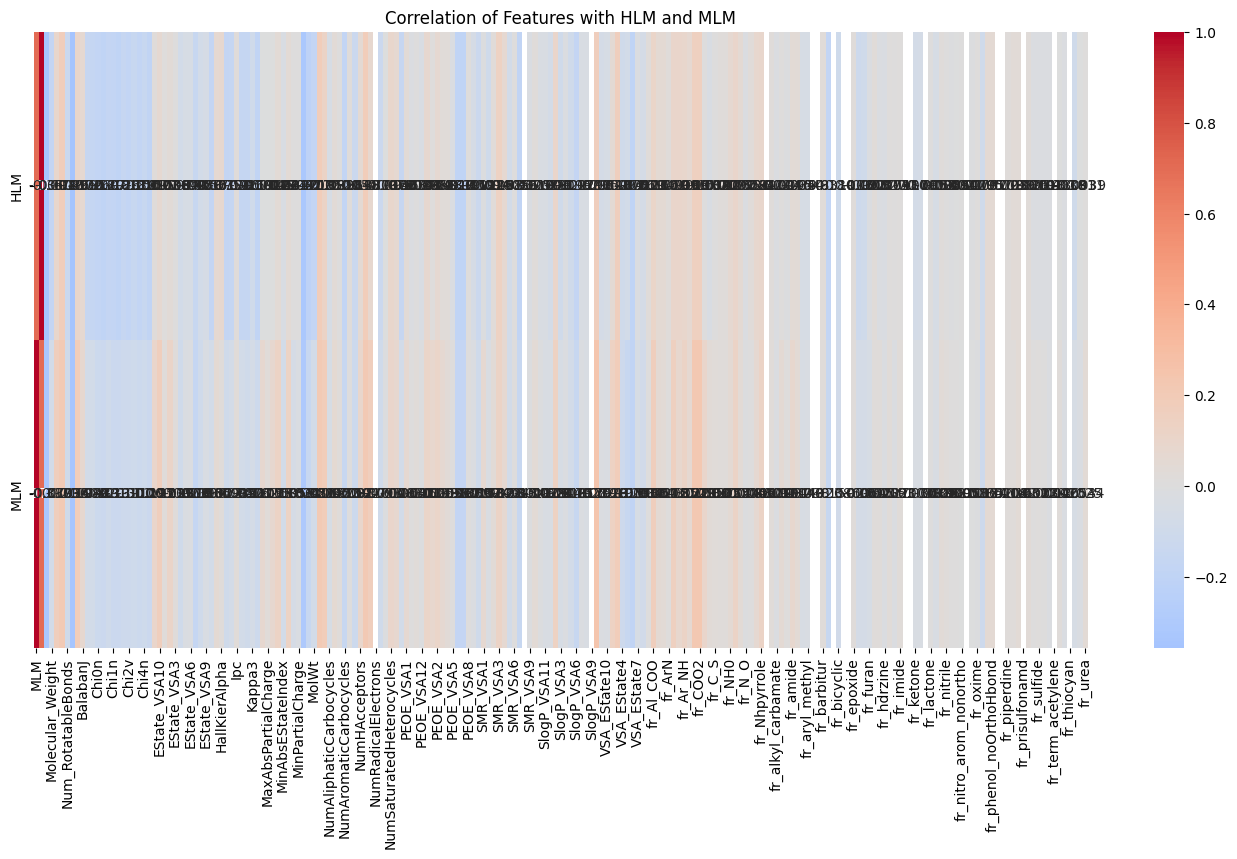

In [ ]:
correlation_matrix = train_drop_odj.corr()

correlations = correlation_matrix.loc[['HLM', 'MLM'], :]

plt.figure(figsize=(17, 8))
sns.heatmap(correlations, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation of Features with HLM and MLM')
plt.show()

In [ ]:
# 둘다 relation 넘는 feature 모음 / 85 columns
filtered_features_00 = train_drop_odj.columns[(abs(correlation_matrix['HLM']) >= relation) & (abs(correlation_matrix['MLM']) >= relation)]

train_drop_feature_00 = train[['SMILES'] + list(filtered_features_00)]
train_drop_feature_00.to_csv('./Data/result/h&m_and.csv', index=False)

# 하나라도 relation 넘는 feature 모음 / 118 columns
filtered_features_01 = train_drop_odj.columns[(abs(correlation_matrix['HLM']) >= relation) | (abs(correlation_matrix['MLM']) >= relation)]

train_drop_feature_01 = train[['SMILES'] + list(filtered_features_01)]
train_drop_feature_01.to_csv('./Data/result/h&m_or.csv', index=False)

# mlm 만 구할때 / 102 columns
filtered_features_02 = train_drop_odj.columns[(abs(correlation_matrix['MLM']) >= relation)]

train_drop_feature_02 = train[list(filtered_features_02)].drop('HLM', axis=1)
train_drop_feature_02.to_csv('./Data/result/mlm_or.csv', index=False)

# hlm 만 구할때 / 98 columns
filtered_features_03 = train_drop_odj.columns[(abs(correlation_matrix['HLM']) >= relation)]

train_drop_feature_03 = train[list(filtered_features_03)]
train_drop_feature_03.to_csv('./Data/result/hlm_or.csv', index=False)


In [ ]:
correlation_matrix

,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,ExactMolWt,FractionCSP3,HallKierAlpha,HeavyAtomCount,HeavyAtomMolWt,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,MaxAbsEStateIndex,MaxAbsPartialCharge,MaxEStateIndex,MaxPartialCharge,MinAbsEStateIndex,MinAbsPartialCharge,MinEStateIndex,MinPartialCharge,MolLogP,MolMR,MolWt,NHOHCount,NOCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRadicalElectrons,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,NumValenceElectrons,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,RingCount,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA8,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,SlogP_VSA9,TPSA,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,fr_Al_COO,fr_Al_OH,fr_Al_OH_noTert,fr_ArN,fr_Ar_COO,fr_Ar_N,fr_Ar_NH,fr_Ar_OH,fr_COO,fr_COO2,fr_C_O,fr_C_O_noCOO,fr_C_S,fr_HOCCN,fr_Imine,fr_NH0,fr_NH1,fr_NH2,fr_N_O,fr_Ndealkylation1,fr_Ndealkylation2,fr_Nhpyrrole,fr_SH,fr_aldehyde,fr_alkyl_carbamate,fr_alkyl_halide,fr_allylic_oxid,fr_amide,fr_amidine,fr_aniline,fr_aryl_methyl,fr_azide,fr_azo,fr_barbitur,fr_benzene,fr_benzodiazepine,fr_bicyclic,fr_diazo,fr_dihydropyridine,fr_epoxide,fr_ester,fr_ether,fr_furan,fr_guanido,fr_halogen,fr_hdrzine,fr_hdrzone,fr_imidazole,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
MLM,1.000000,0.705898,-0.330219,-0.079085,0.166818,0.209233,-0.094201,-0.349274,0.186663,0.073863,-0.081238,-0.080421,-0.120640,-0.126571,-0.101108,-0.127862,-0.130362,-0.111733,-0.114897,-0.105395,-0.120513,-0.101839,-0.123507,0.094760,0.167250,0.022640,0.112231,0.023367,-0.096813,-0.023334,-0.012490,-0.162947,-0.096449,-0.034130,-0.080987,0.049668,0.022159,-0.093382,-0.073551,0.029454,-0.081781,-0.101759,-0.060230,-0.111789,0.075406,0.026341,0.075406,0.129868,-0.084532,0.131138,-0.058354,-0.023505,-0.307201,-0.145424,-0.081006,0.207191,0.189302,-0.045108,0.057257,0.021568,-0.153475,0.008757,-0.118515,0.093634,0.215440,0.167002,NaN,-0.092928,-0.010668,0.101221,0.075905,-0.083248,0.063248,0.004677,0.025800,-0.010244,0.105975,0.080196,0.110030,0.065214,0.038023,0.000617,-0.180423,-0.171810,0.008471,-0.014540,-0.096620,0.072303,-0.024291,0.031986,0.121341,0.067608,-0.079877,0.004335,-0.151788,NaN,-0.010683,0.046061,-0.007802,-0.028652,-0.028403,0.132683,-0.043790,-0.018495,-0.078656,-0.151482,-0.017337,-0.028246,NaN,0.247617,-0.020713,-0.023355,0.132233,0.188296,-0.116261,-0.147914,-0.189688,-0.052649,-0.087442,0.004162,0.163830,0.050716,0.042960,0.011872,0.148446,0.085374,0.118629,0.071791,0.223371,0.223371,0.094963,0.036476,0.026761,0.020666,0.020284,0.055366,0.118992,0.044251,-0.008815,0.004921,0.065560,0.118629,NaN,0.029454,-0.012200,0.048935,0.010752,0.086618,0.043516,-0.042522,-0.037653,NaN,NaN,0.022703,-0.153475,NaN,-0.086301,NaN,NaN,0.021019,-0.060112,-0.063659,-0.051552,0.014797,0.023044,-0.014537,0.026850,-0.020891,0.029596,NaN,NaN,-0.036123,-0.

In [ ]:
train_drop_odj['AlogP'].isna().sum()

0

In [ ]:
len(filtered_features_00)

85